# Time Series Forecast Projects

## 5-Step Forecasting Task
The 5 basic steps in a forecasting task are summarized by Hyndman and Athana­sopou­los in their book Forecasting: principles and practice. These steps are:

1. **Problem Definition.** The careful consideration of who requires the forecast and how the forecast will be used. 
This is described as the most difficult part of the process, most likely because it is entirely problem specific and subjective.
2. **Gathering Information.** The collection of historical data to analyze and model. This also includes getting access to domain experts and gathering information that can help to best interpret the historical information, and ultimately the forecasts that will be made.
3. **Preliminary Exploratory Analysis.** The use of simple tools, like graphing and summary statistics, to better understand the data. Review plots and summarize and note obvious temporal structures, like trends seasonality, anomalies like missing data, corruption, and outliers, and any other structures that may impact forecasting.
4. **Choosing and Fitting Models.** Evaluate two, three, or a suite of models of varying types on the problem. Models may be chosen for evaluation based on the assumptions they make and whether the dataset conforms. Models are configured and fit to the historical data.
5. **Using and Evaluating a Forecasting Model.** The model is used to make forecasts and the performance of those forecasts is evaluated and skill of the models estimated. This may involve back-testing with historical data or waiting for new observations to become available for comparison.

![](./data/5_setp.png)

## Iterative Forecast Development Process
The authors Shmueli and Lichtendahl in their book Practical Time Series Forecasting with R: A Hands-On Guide suggest an 8-step process.

This process extends beyond the development of a model and making forecasts and involves iterative loops.

Their process can be summarized as follows:

- Define Goal.
- Get Data.
- Explore and Visualize Series.
- Pre-Process Data.
- Partition Series.
- Apply Forecasting Method/s.
- Evaluate and Compare Performance.
- Implement Forecasts/Systems.

Below are the iterative loops within the process:

- Explore and Visualize Series => Get Data. Data exploration can lead to questions that require access to new data.
- Evaluate and Compare Performance => Apply Forecasting Method/s. The evaluation of models may raise questions or ideas for new methods or new method configurations to try.

The process is more focused on the ongoing development and refinement of one or more models on the problem until an acceptable level of performance is achieved.

![](./data/Iterative_Forecast_Development_Process.png)

## Suggestions and Tips
This section lists 10 suggestions and tips to consider when working through your time series forecasting project.

The thrust of these suggestions is centered on the premise that you cannot know what will work, let alone which methods will work well on your problem beforehand. And that the best source of knowledge on a forecasting project comes from the results of trial and error with real historical data.

1. Select or devise a time series forecast process that is tailored to your project, tools, team, and level of expertise.
2. Write down all assumptions and questions you have during analysis and forecasting work, then revisit them later and seek to answer them with small experiments on historical data.
3. Review a large number of plots of your data at different time scales, zooms, and transforms of observations in an effort to help make exploitable structures present in the data obvious to you.
4. Develop a robust test harness for evaluating models using a meaningful performance measure and a reliable test strategy, such as walk-forward validation (rolling forecast).
5. Start with simple naive forecast models to provide a baseline of performance for more sophisticated methods to improve upon.
6. Create a large number of perspectives or views on your time series data, including a suite of automated transforms, and evaluate each with one or a suite of models in order to help automatically discover non-intuitive representations and model combinations that result in good predictions for your problem.
7. Try a suite of models of differing types on your problem, from simple to more advanced approaches.
8. Try a suite of configurations for a given problem, including configurations that have worked well on other problems.
9. Try automated hyperparameter optimization methods for models to flush out a suite of well-performing models as well as non-intuitive model configurations that you would not have tried manually.
10.  Devise automated tests of performance and skill for ongoing predictions to help to automatically determine if and when a model has become stale and requires review or retraining.

# Project: Monthly Sales of French Champagne
## Overview
In this tutorial, we will work through a time series forecasting project from end-to-end, from downloading the dataset and defining the problem to training a final model and making predictions. This project is not exhaustive, but shows how you can get good results quickly by working through a time series forecasting problem systematically. The steps of this project that we will work through are as follows:
1. Problem Description. 
2. Test Harness.
3. Persistence.
4. Data Analysis.
5. ARIMA Models.
6. Model Validation.

In [35]:
# check the versions of key python libraries
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)

scipy: 1.9.1
numpy: 1.21.6
matplotlib: 3.5.2
pandas: 1.4.2
statsmodels: 0.13.2
sklearn: 1.0.2


In [36]:
# split into a training and validation dataset
from pandas import read_csv
series = read_csv('./champagne/champagne.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('./champagne/champagne_dataset.csv', header=False)
validation.to_csv('./champagne/champagne_validation.csv', header=False)

Dataset 93, Validation 12


## Problem Description
The problem is to predict the number of monthly sales of champagne for the Perrin Freres label (named for a region in France).

The dataset provides the number of monthly sales of champagne from January 1964 to September 1972, or just under 10 years of data.

The values are a count of millions of sales and there are 105 observations.

## Model Evaluation
Model evaluation will only be performed on the data in dataset.csv prepared in the previous section.

Model evaluation involves two elements:

- Performance Measure.
- Test Strategy.

## Test Strategy
Candidate models will be evaluated using walk-forward validation. This is because a rolling- forecast type model is required from the problem definition. This is where one-step forecasts are needed given all available data. The walk-forward validation will work as follows:
1. The first 50% of the dataset will be held back to train the model.
2. The remaining 50% of the dataset will be iterated and test the model. 
3. For each step in the test dataset:
- (a) A model will be trained.
- (b) A one-step prediction made and the prediction stored for later evaluation.
- (c) The actual observation from the test dataset will be added to the training dataset for the next iteration.
4. The predictions made during the iteration of the test dataset will be evaluated and an RMSE score reported.

In [37]:

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

## Persistence
The first step before getting bogged down in data analysis and modeling is to establish a baseline of performance. 

This will provide both a template for evaluating models using the proposed test harness and a performance measure by which all more elaborate predictive models can be compared. 

**The baseline prediction for time series forecasting is called the naive forecast, or persistence.** 

This is where the observation from the previous time step is used as the prediction for the observation at the next time step. 


In [38]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
series = read_csv('./champagne/champagne_dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	yhat = history[-1]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=5428.000, Expected=8314.000
>Predicted=8314.000, Expected=10651.000
>Predicted=10651.000, Expected=3633.000
>Predicted=3633.000, Expected=4292.000
>Predicted=4292.000, Expected=4154.000
>Predicted=4154.000, Expected=4121.000
>Predicted=4121.000, Expected=4647.000
>Predicted=4647.000, Expected=4753.000
>Predicted=4753.000, Expected=3965.000
>Predicted=3965.000, Expected=1723.000
>Predicted=1723.000, Expected=5048.000
>Predicted=5048.000, Expected=6922.000
>Predicted=6922.000, Expected=9858.000
>Predicted=9858.000, Expected=11331.000
>Predicted=11331.000, Expected=4016.000
>Predicted=4016.000, Expected=3957.000
>Predicted=3957.000, Expected=4510.000
>Predicted=4510.000, Expected=4276.000
>Predicted=4276.000, Expected=4968.000
>Predicted=4968.000, Expected=4677.000
>Predicted=4677.000, Expected=3523.000
>Predicted=3523.000, Expected=1821.000
>Predicted=1821.000, Expected=5222.000
>Predicted=5222.000, Expected=6872.000
>Predicted=6872.000, Expected=10803.000
>Predicted=10803.000

## Data Analysis
We can use summary statistics and plots of the data to quickly learn more about the structure of the prediction problem. In this section, we will look at the data from four perspectives:
1. Summary Statistics.
2. Line Plot.
3. Density Plots.
4. Box and Whisker Plot.


In [39]:
print(series.describe())

count       93.000000
mean      4641.118280
std       2486.403841
min       1573.000000
25%       3036.000000
50%       4016.000000
75%       5048.000000
max      13916.000000
Name: 1, dtype: float64


The number of observations (count) matches our expectation, meaning we are handling the data correctly.

The mean is about 173, which we might consider our level in this series.

The standard deviation (average spread from the mean) is relatively large at 112 robberies. 

The percentiles along with the standard deviation do suggest a large spread to the data

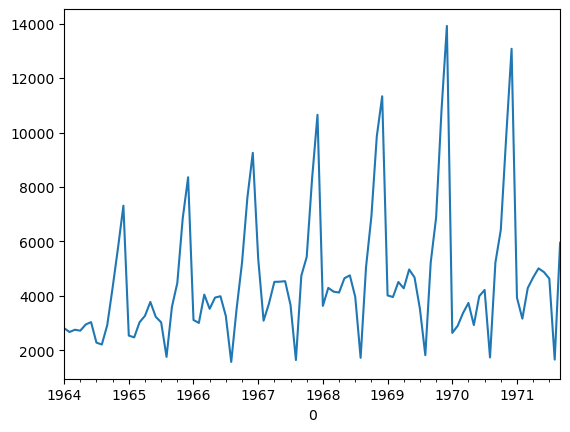

In [40]:
from matplotlib import pyplot

series.plot()
pyplot.show()

Some observations from the plot include:

There may be an increasing trend of sales over time.

There appears to be systematic seasonality to the sales for each year.

The seasonal signal appears to be growing over time, suggesting a multiplicative relationship (increasing change).

There do not appear to be any obvious outliers.

The seasonality suggests that the series is almost certainly non-stationary.

## Seasonal Line Plots
We can confirm the assumption that the seasonality is a yearly cycle by eyeballing line plots of the dataset by year.

The example below takes the 7 full years of data as separate groups and creates one line plot for each. The line plots are aligned vertically to help spot any year-to-year pattern.

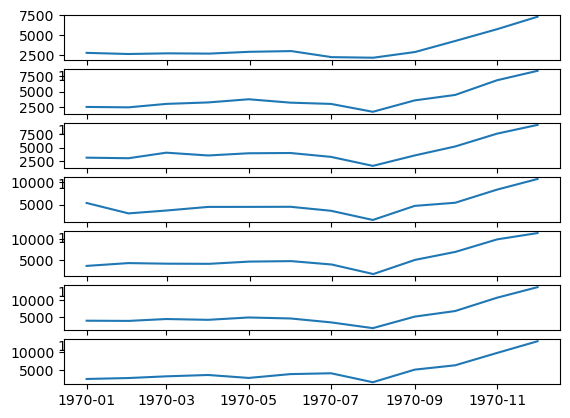

In [41]:
from pandas import read_csv
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
# series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
groups = series['1964':'1970'].groupby(Grouper(freq='A'))
years = DataFrame()
pyplot.figure()
i = 1
n_groups = len(groups)
for name, group in groups:
	pyplot.subplot((n_groups*100) + 10 + i)
	i += 1
	pyplot.plot(group)
pyplot.show()

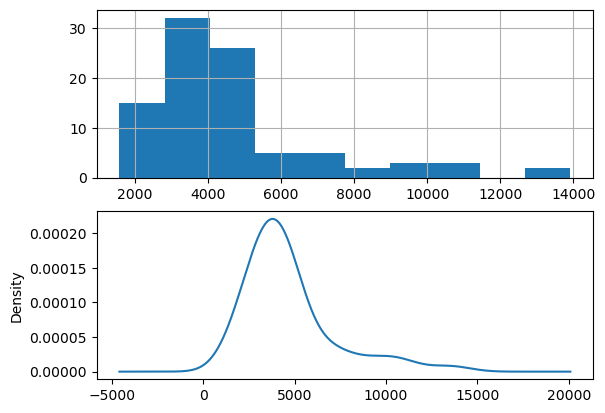

In [42]:
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

Some observations from the plots include:
- The distribution is not Gaussian.
- The shape has a long right tail and may suggest an exponential distribution


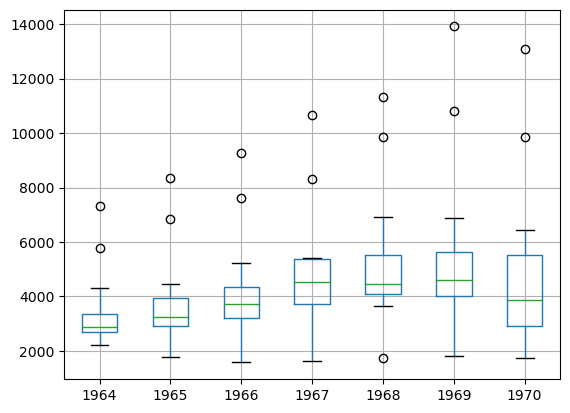

In [43]:
from pandas import *

groups = series['1964':'1970'].groupby(Grouper(freq='A'))
years = DataFrame()
for name, group in groups:
	years[name.year] = group.values
years.boxplot()
pyplot.show()

Some observations from reviewing the plots include:

- The median values for each year (red line) may show an increasing trend.
- The spread or middle 50% of the data (blue boxes) does appear reasonably stable.
- There are outliers each year (black crosses); these may be the tops or bottoms of the seasonal cycle.
- The last year, 1970, does look different from the trend in prior years


## ARIMA Models
In this section, we will develop Autoregressive Integrated Moving Average, or ARIMA, models for the problem. We will approach this in four steps:
1. Developing a manually configured ARIMA model.
2. Using a grid search of ARIMA to find an optimized model.
3. Analysis of forecast residual errors to evaluate any bias in the model. 
4. Explore improvements to the model using power transforms.

In [44]:
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller

# create a differe
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return Series(diff)

X = series.values
# difference data
stationary = difference(X)
stationary.index = series.index[1:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# save
# save
stationary.to_csv('./champagne/champagne_stationary.csv', header=False)
# stationary.to_csv('./data/stationary.csv' class="crayon-t">, header=False</span>)

ADF Statistic: -24.174014
p-value: 0.000000
Critical Values:
	1%: -3.514
	5%: -2.898
	10%: -2.586


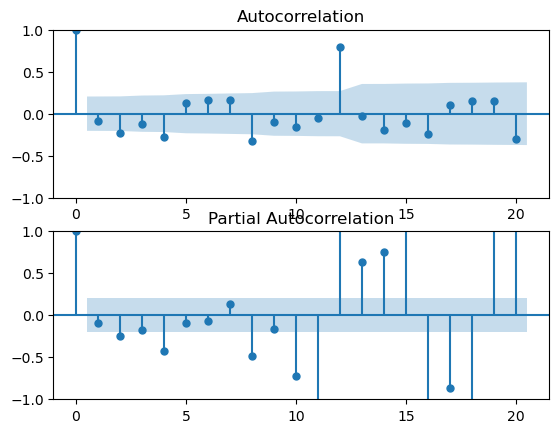

In [45]:
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
series = read_csv('./champagne/champagne_stationary.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, ax=pyplot.gca())
pyplot.show()

Below are some observations from the plots.

- The ACF shows a significant lag for 1 month.
- The PACF shows a significant lag for 1 month, with perhaps some significant lag at 12 and 13 months.
- Both the ACF and PACF show a drop-off at the same point, perhaps suggesting a mix of AR and MA

A good starting point for the p and q values is also 1.



In [46]:
# evaluate manually configured ARIMA model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = read_csv('./champagne/champagne_dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=8076.988, Expected=8314.000
>Predicted=9747.153, Expected=10651.000
>Predicted=5994.377, Expected=3633.000
>Predicted=3820.277, Expected=4292.000
>Predicted=4041.968, Expected=4154.000
>Predicted=4990.405, Expected=4121.000
>Predicted=5129.641, Expected=4647.000
>Predicted=5031.196, Expected=4753.000
>Predicted=4133.285, Expected=3965.000
>Predicted=2095.321, Expected=1723.000
>Predicted=5216.271, Expected=5048.000
>Predicted=5866.317, Expected=6922.000
>Predicted=8591.060, Expected=9858.000
>Predicted=11028.649, Expected=11331.000
>Predicted=4090.352, Expected=4016.000
>Predicted=4767.109, Expected=3957.000
>Predicted=4656.326, Expected=4510.000
>Predicted=4577.708, Expected=4276.000
>Predicted=5108.656, Expected=4968.000
>Predicted=5202.831, Expected=4677.000
>Predicted=4423.982, Expected=3523.000
>Predicted=2162.388, Expected=1821.000
>Predicted=5463.233, Expected=5222.000
>Predicted=7331.345, Expected=6872.000
>Predicted=10258.650, Expected=10803.000
>Predicted=11732.476

##  Grid Search ARIMA Hyperparameters
Many ARIMA configurations are unstable on this dataset, but there may be other hyperparam- eters that result in a well-performing model. In this section, we will search values of p, d, and q for combinations that do not result in error, and find the combination that results in the best performance. We will use a grid search to explore all combinations in a subset of integer values. Specifically, we will search all combinations of the following parameters:

- p: 0 to 12. 
- d: 0 to 3. 
- q: 0 to 12.

This is (13 * 4 * 13), or 676, runs of the test harness and will take some time to execute.



In [47]:
# grid search ARIMA parameters for time series
import warnings
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		months_in_year = 12
		diff = difference(history, months_in_year)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, months_in_year)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
# series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=947.677
ARIMA(0, 0, 1) RMSE=948.007
ARIMA(0, 0, 2) RMSE=973.907
ARIMA(0, 1, 0) RMSE=1145.923
ARIMA(0, 1, 1) RMSE=959.118
ARIMA(0, 1, 2) RMSE=958.599
ARIMA(0, 2, 0) RMSE=1930.801
ARIMA(0, 2, 1) RMSE=1157.260
ARIMA(0, 2, 2) RMSE=958.327
ARIMA(1, 0, 0) RMSE=945.107
ARIMA(1, 0, 1) RMSE=979.293
ARIMA(1, 0, 2) RMSE=975.297
ARIMA(1, 1, 0) RMSE=1071.385
ARIMA(1, 1, 1) RMSE=961.550
ARIMA(1, 1, 2) RMSE=961.336
ARIMA(1, 2, 0) RMSE=1560.305
ARIMA(1, 2, 1) RMSE=1081.849
ARIMA(1, 2, 2) RMSE=966.882
ARIMA(2, 0, 0) RMSE=962.750
ARIMA(2, 0, 1) RMSE=988.751
ARIMA(2, 0, 2) RMSE=1005.726
ARIMA(2, 1, 0) RMSE=1031.490
ARIMA(2, 1, 1) RMSE=971.914
ARIMA(2, 1, 2) RMSE=978.445
ARIMA(2, 2, 0) RMSE=1352.151
ARIMA(2, 2, 1) RMSE=1041.759
ARIMA(2, 2, 2) RMSE=1026.343
Best ARIMA(1, 0, 0) RMSE=945.107


## Review Residual Errors
A good final check of a model is to review residual forecast errors. Ideally, the distribution of residual errors should be a Gaussian with a zero mean. We can check this by plotting the residuals with a histogram and density plots. The example below calculates the residual errors for predictions on the test set and creates these density plots.

RMSE: 997.006
                 0
count    47.000000
mean   -370.174826
std     935.746183
min   -2491.298691
25%    -874.947008
50%    -394.840775
75%     167.709908
max    2025.117739


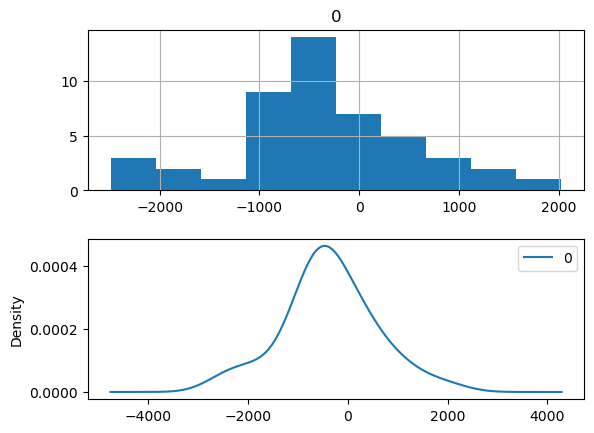

In [48]:
# plots of residual errors of bias corrected forecasts
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
# series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 165.904728
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,0,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

In [49]:
train, test

(array([2815., 2672., 2755., 2721., 2946., 3036., 2282., 2212., 2922.,
        4301., 5764., 7312., 2541., 2475., 3031., 3266., 3776., 3230.,
        3028., 1759., 3595., 4474., 6838., 8357., 3113., 3006., 4047.,
        3523., 3937., 3986., 3260., 1573., 3528., 5211., 7614., 9254.,
        5375., 3088., 3718., 4514., 4520., 4539., 3663., 1643., 4739.,
        5428.], dtype=float32),
 array([ 8314., 10651.,  3633.,  4292.,  4154.,  4121.,  4647.,  4753.,
         3965.,  1723.,  5048.,  6922.,  9858., 11331.,  4016.,  3957.,
         4510.,  4276.,  4968.,  4677.,  3523.,  1821.,  5222.,  6872.,
        10803., 13916.,  2639.,  2899.,  3370.,  3740.,  2927.,  3986.,
         4217.,  1738.,  5221.,  6424.,  9842., 13076.,  3934.,  3162.,
         4286.,  4676.,  5010.,  4874.,  4633.,  1659.,  5951.],
       dtype=float32))

                 0
count    47.000000
mean   -204.270098
std     935.746183
min   -2325.393963
25%    -709.042280
50%    -228.936047
75%     333.614636
max    2191.022467


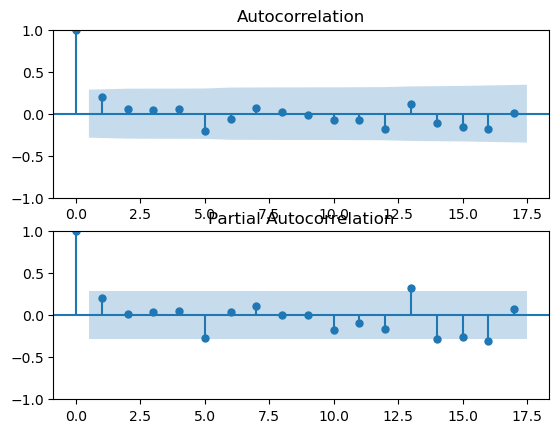

In [50]:
# ACF and PACF plots of residual errors of bias corrected forecasts
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
# series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,0,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
plot_acf(residuals, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(residuals, ax=pyplot.gca())
pyplot.show()

## Box-Cox Transformed Dataset
The Box-Cox transform is a method that is able to evaluate a suite of power transforms, including, but not limited to, log, square root, and reciprocal transforms of the data.

Some observations from these plots are follows:

- The large fluctuations have been removed from the line plot of the time series.
- The histogram shows a flatter or more uniform (well behaved) distribution of values.
- The Q-Q plot is reasonable, but still not a perfect fit for a Gaussian distribution.

Lambda: -0.233770


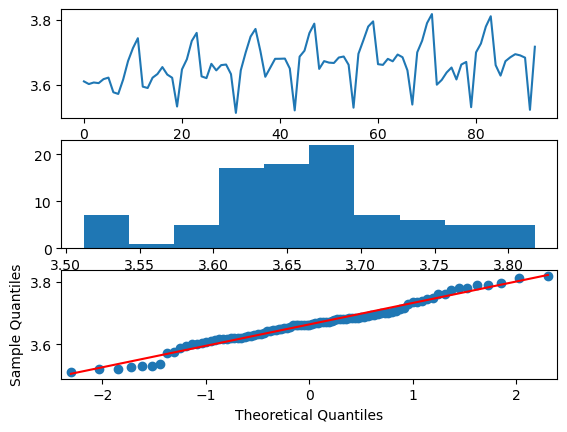

In [51]:
from pandas import read_csv
from pandas import DataFrame
from scipy.stats import boxcox
from matplotlib import pyplot
from statsmodels.graphics.gofplots import qqplot
# series = read_csv('dataset.csv')
X = series.values
transformed, lam = boxcox(X)
print('Lambda: %f' % lam)
pyplot.figure(1)
# line plot
pyplot.subplot(311)
pyplot.plot(transformed)
# histogram
pyplot.subplot(312)
pyplot.hist(transformed)
# q-q plot
pyplot.subplot(313)
qqplot(transformed, line='r', ax=pyplot.gca())
pyplot.show()

In [52]:
# evaluate ARIMA models with box-cox transformed time series
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from math import log
from math import exp
from scipy.stats import boxcox

# invert box-cox transform
def boxcox_inverse(value, lam):
	if lam == 0:
		return exp(value)
	return exp(log(lam * value + 1) / lam)

# load data
# series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# transform
	transformed, lam = boxcox(history)
	if lam < -5:
		transformed, lam = history, 1
	# predict
	model = ARIMA(transformed, order=(0,1,2))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	# invert transformed prediction
	yhat = boxcox_inverse(yhat, lam)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=4037.570, Expected=8314.000
>Predicted=7240.571, Expected=10651.000
>Predicted=7406.927, Expected=3633.000
>Predicted=2125.667, Expected=4292.000
>Predicted=6656.102, Expected=4154.000
>Predicted=3252.260, Expected=4121.000
>Predicted=5147.700, Expected=4647.000
>Predicted=4478.818, Expected=4753.000
>Predicted=4930.713, Expected=3965.000
>Predicted=4106.157, Expected=1723.000
>Predicted=2934.104, Expected=5048.000
>Predicted=5898.286, Expected=6922.000
>Predicted=5326.546, Expected=9858.000
>Predicted=8035.598, Expected=11331.000
>Predicted=7775.039, Expected=4016.000
>Predicted=2422.388, Expected=3957.000
>Predicted=6398.106, Expected=4510.000
>Predicted=3953.009, Expected=4276.000
>Predicted=5334.730, Expected=4968.000
>Predicted=4882.465, Expected=4677.000
>Predicted=4951.488, Expected=3523.000
>Predicted=3985.418, Expected=1821.000
>Predicted=3236.008, Expected=5222.000
>Predicted=6283.660, Expected=6872.000
>Predicted=5353.998, Expected=10803.000
>Predicted=9194.407, E

## Model Validation
After models have been developed and a final model selected, it must be validated and finalized.

Validation is an optional part of the process, but one that provides a ‘last check’ to ensure we have not fooled or lied to ourselves.

This section includes the following steps:

- Finalize Model: Train and save the final model.
- Make Prediction: Load the finalized model and make a prediction.
- Validate Model: Load and validate the final model.

## Finalize Model
Finalizing the model involves fitting an ARIMA model on the entire dataset, in this case, on a transformed version of the entire dataset.

Once fit, the model can be saved to file for later use. Because a Box-Cox transform is also performed on the data, we need to know the chosen lambda so that any predictions from the model can be converted back to the original, untransformed scale.

In [56]:
# save finalized model
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
import numpy

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# load data
# series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
diff = difference(X, months_in_year)
# fit model
model = ARIMA(diff, order=(0,0,1))
model_fit = model.fit()
# bias constant, could be calculated from in-sample mean residual
bias = 165.904728
# save model
model_fit.save('./champagne/model.pkl')
numpy.save('./champagne/model_bias.npy', [bias])

- model.pkl This is the ARIMAResult object from the call to ARIMA.fit(). This includes the coefficients and all other internal data returned when fitting the model.
- model_lambda.npy This is the lambda value stored as a one-row, one-column NumPy array.

This is probably overkill and all that is really needed for operational use are the AR and MA coefficients from the model, the d parameter for the number of differences, perhaps the lag observations and model residuals, and the lambda value for the transform.

## Make Prediction
A natural case may be to load the model and make a single forecast.

This is relatively straightforward and involves restoring the saved model and the lambda and calling the forecast() method.

In [57]:

# load finalized model and make a prediction
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMAResults
import numpy
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
months_in_year = 12
model_fit = ARIMAResults.load('./champagne/model.pkl')
bias = numpy.load('./champagne/model_bias.npy')
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, months_in_year)
print('Predicted: %.3f' % yhat)

Predicted: 7004.078


## Validate Model
We can load the model and use it in a pretend operational manner.

In the test harness section, we saved the final 12 months of the original dataset in a separate file to validate the final model.

We can load this validation.csv file now and use it see how well our model really is on “unseen” data.

There are two ways we might proceed:

Load the model and use it to forecast the next 12 months. The forecast beyond the first one or two months will quickly start to degrade in skill.
Load the model and use it in a rolling-forecast manner, updating the transform and model for each time step. This is the preferred method as it is how one would use this model in practice, as it would achieve the best performance.

>Predicted=7004.078, Expected=6981.000
>Predicted=10356.627, Expected=9851.000
>Predicted=13493.317, Expected=12670.000
>Predicted=4278.689, Expected=4348.000
>Predicted=3684.166, Expected=3564.000
>Predicted=4772.002, Expected=4577.000
>Predicted=5147.157, Expected=4788.000
>Predicted=5446.633, Expected=4618.000
>Predicted=5209.065, Expected=5312.000
>Predicted=5153.854, Expected=4298.000
>Predicted=1988.539, Expected=1413.000
>Predicted=6326.844, Expected=5877.000
RMSE: 506.921


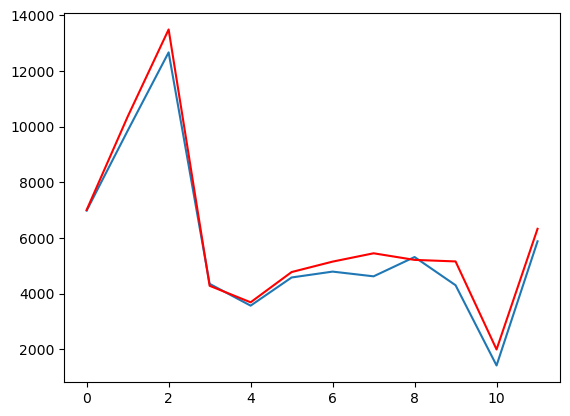

In [58]:
# load and evaluate the finalized model on the validation dataset
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load and prepare datasets
# dataset = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
validation = read_csv('./champagne/champagne_validation.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
y = validation.values.astype('float32')
# load model
# model_fit = ARIMAResults.load('model.pkl')
# bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,0,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()

This section lists some ideas.

- Statistical Significance Tests. Use a statistical test to check if the difference in results between different models is statistically significant. The Student t-test would be a good place to start.
- Grid Search with Data Transforms. Repeat the grid search in the ARIMA hyperparameters with the Box-Cox transform and see if a different and better set of parameters can be achieved.
- Inspect Residuals. Investigate the residual forecast errors on the final model with Box-Cox transforms to see if there is a further bias and/or autocorrelation that can be addressed.
- Lean Model Saving. Simplify model saving to only store the required coefficients rather than the entire ARIMAResults object.
- Manually Handle Trend. Model the trend directly with a linear or nonlinear model and explicitly remove it from the series. This may result in better performance if the trend is nonlinear and can be modeled better than the linear case.
- Confidence Interval. Display the confidence intervals for the predictions on the validation dataset.
- Data Selection. Consider modeling the problem without the first two years of data and see if this has an impact on forecast skill.